#  Решение задачи регрессии при помощи пакета `torch`. Метрики.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://github.com/Lightning-AI/torchmetrics
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://pytorch-lightning.readthedocs.io/en/2.1.2/pytorch/ecosystem/metrics.html#torchmetrics

## Задачи для совместного разбора

In [1]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th

Scalar = TensorType[()]
patch_typeguard()

1\. Используя реализацию из `torch.nn`, решите задачу регрессии. Для расчета градиентов воспользуйтесь возможностями по автоматическому дифференцированию `torch`. В качестве функции потерь используйте собственную реализацию MSE. Для настройки весов реализуйте пакетный градиентный спуск с использованием `torch.optim.SGD`.

In [2]:
from sklearn.datasets import make_regression
import torch as th

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y)

In [3]:
import torch.nn as nn

class SyntRegressionModel(nn.Module):
  def __init__(self, n_inputs: int, n_hidden: int) -> None:
    super().__init__()

    self.fc1 = nn.Linear(in_features=n_inputs, out_features=n_hidden)
    self.fc2 = nn.Linear(in_features=n_hidden, out_features=1)

    self.relu = nn.ReLU()

  def forward(self, X: th.Tensor) -> th.Tensor:
    out = self.fc1(X)
    # out = out.relu()
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [4]:
model = SyntRegressionModel(n_inputs=4, n_hidden=2)
# y_pred = model.forward(X)
y_pred = model(X)

In [5]:
model.fc1.weight

Parameter containing:
tensor([[ 0.4406, -0.1616, -0.3210, -0.4764],
        [-0.2773,  0.1344,  0.3040,  0.3025]], requires_grad=True)

In [6]:
y_pred.shape

torch.Size([100, 1])

In [7]:
n_inputs = 4
n_hidden = 1

model = nn.Sequential(
    nn.Linear(in_features=n_inputs, out_features=n_hidden),
    nn.ReLU(),
    nn.Linear(in_features=n_hidden, out_features=1),
)

In [8]:
y_pred = model(X)

In [9]:
criterion = nn.MSELoss()

loss = criterion(y_pred.flatten(), y)
loss

tensor(9557.4873, grad_fn=<MseLossBackward0>)

In [10]:
loss.backward()

In [11]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
optimizer.step()
optimizer.zero_grad()

In [13]:
n_inputs = 4
n_hidden = 1

model = nn.Sequential(
    nn.Linear(in_features=n_inputs, out_features=n_hidden),
    nn.ReLU(),
    nn.Linear(in_features=n_hidden, out_features=1),
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for _ in range(100):
  # forward pass
  y_pred = model(X)
  loss = criterion(y_pred.flatten(), y)

  # backprop
  loss.backward()

  # gradient descend
  optimizer.step()
  optimizer.zero_grad()

In [14]:
loss

tensor(3221.5334, grad_fn=<MseLossBackward0>)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

n_inputs = 4
n_hidden = 1

model = nn.Sequential(
    nn.Linear(in_features=n_inputs, out_features=1),
    # nn.ReLU(),
    # nn.Linear(in_features=n_hidden, out_features=1),
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

epoch_losses = []
for epoch in range(100):
  epoch_loss = 0
  for X_batch, y_batch in loader:
    # forward pass
    y_pred = model(X_batch)
    loss = criterion(y_pred.flatten(), y_batch)
    epoch_loss += loss
    # backprop
    loss.backward()
    
    # gradient descend
    optimizer.step()
    optimizer.zero_grad()
  epoch_loss = epoch_loss / len(loader)
  epoch_losses.append( epoch_loss.item())
  print(epoch, epoch_loss.item())

0 9073.9892578125
1 7469.4931640625
2 6832.89990234375
3 5633.7685546875
4 5592.2197265625
5 4232.591796875
6 4392.71923828125
7 3558.42138671875
8 3133.82958984375
9 3053.951171875
10 2291.84033203125
11 1860.341796875
12 1817.928466796875
13 1475.4691162109375
14 1444.5306396484375
15 1251.1845703125
16 1013.8018188476562
17 934.5423583984375
18 806.0316772460938
19 784.5026245117188
20 570.4441528320312
21 605.8565673828125
22 497.5271301269531
23 441.263427734375
24 368.8858947753906
25 331.9432067871094
26 247.84963989257812
27 224.12318420410156
28 222.60372924804688
29 174.9130096435547
30 154.6103515625
31 142.79702758789062
32 122.4976806640625
33 118.42048645019531
34 102.91638946533203
35 96.42542266845703
36 82.52526092529297
37 72.77928161621094
38 61.99543380737305
39 53.37956619262695
40 48.33488845825195
41 44.113712310791016
42 40.487701416015625
43 34.160789489746094
44 29.196483612060547
45 26.120161056518555
46 26.56832504272461
47 22.39176368713379
48 18.9696655273

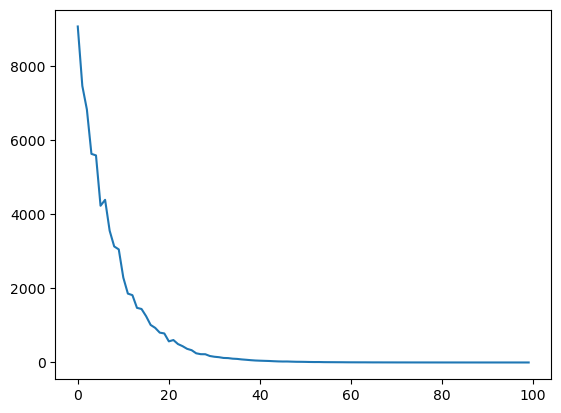

In [16]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)

In [17]:
def train(model, loader, n_epochs, criterion, optimizer, print_every):
  model.train()
  pass

In [18]:
@th.no_grad()
def eval(model):
  model.eval()

In [19]:
with th.no_grad():
  y_pred = model(X)
  print(y_pred.flatten())

tensor([-142.2327,   -3.9941,   -0.3483,  -33.5069,   26.5022,  -22.1205,
          98.1251,   73.1941,  124.3022,  -13.0347, -129.9179,    7.0646,
        -129.8048,  -40.5980,  219.9594, -133.8475,    0.6375,  -55.1693,
         -65.0434,   42.2850, -146.0386,  -67.8697,  -34.7308,  -82.4570,
          52.6007, -175.1890,  -37.6258, -104.9261, -142.3101,  140.4237,
         -35.0401,   10.7246,   95.4390, -158.3845,   -8.0135,   79.6627,
        -105.7041, -165.9898,  -11.9784,    4.2142,   38.4640,   30.6246,
         -90.5770,  156.5714,  132.5905,   66.0040,    9.4590,  104.9736,
          61.4998,  -77.7685,    9.0133,   59.5976,   75.5726,  -35.1919,
          20.3318,   43.5331,   32.5030,    7.2362,   -4.4763,   94.1793,
         -81.8099,   51.3462,   65.9529,   38.4235,  137.2518,  -74.6157,
         -69.1101,    8.5048, -130.0861, -107.8886,  121.4620,    7.8894,
        -140.5808,  -81.1973,   84.9411,   98.3358,   30.2554,  102.7570,
        -117.2346, -100.1865,  -41.020

In [20]:
with th.no_grad():
  y_pred = model(X)

In [21]:
from sklearn.metrics import r2_score

In [22]:
r2_score(y, y_pred.flatten())

0.999993711326458

In [23]:
#!pip install torchmetrics

In [24]:
import torchmetrics as M

In [25]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

n_inputs = 4
n_hidden = 1

model = nn.Sequential(
    nn.Linear(in_features=n_inputs, out_features=1),
    # nn.ReLU(),
    # nn.Linear(in_features=n_hidden, out_features=1),
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

epoch_losses = []
for epoch in range(100):
  epoch_loss = 0
  r2_metric = M.R2Score()
  for X_batch, y_batch in loader:
    # forward pass
    y_pred = model(X_batch)
    loss = criterion(y_pred.flatten(), y_batch)
    epoch_loss += loss
    r2_metric.update(y_pred.flatten(), y_batch)
    # backprop
    loss.backward()

    # gradient descend
    optimizer.step()
    optimizer.zero_grad()
  epoch_loss = epoch_loss / len(loader)
  epoch_losses.append( epoch_loss.item())
  r2_epoch = r2_metric.compute()
  print(epoch, epoch_loss.item(), r2_epoch)

0 8994.6435546875 tensor(0.0441)
1 7845.0673828125 tensor(0.1676)
2 6636.66455078125 tensor(0.2741)
3 5755.50390625 tensor(0.3624)
4 5155.70703125 tensor(0.4399)
5 4536.8583984375 tensor(0.5083)
6 4124.90380859375 tensor(0.5699)
7 3532.41796875 tensor(0.6245)
8 3082.42041015625 tensor(0.6717)
9 2822.122314453125 tensor(0.7122)
10 2197.7421875 tensor(0.7497)
11 2028.932373046875 tensor(0.7789)
12 1782.9259033203125 tensor(0.8057)
13 1615.562255859375 tensor(0.8291)
14 1415.0592041015625 tensor(0.8502)
15 1321.8294677734375 tensor(0.8686)
16 1051.2247314453125 tensor(0.8860)
17 884.5241088867188 tensor(0.8997)
18 880.5752563476562 tensor(0.9111)
19 846.0089721679688 tensor(0.9224)
20 623.2936401367188 tensor(0.9334)
21 525.346435546875 tensor(0.9413)
22 471.12158203125 tensor(0.9480)
23 436.1064758300781 tensor(0.9540)
24 375.39410400390625 tensor(0.9595)
25 323.6466369628906 tensor(0.9643)
26 309.43438720703125 tensor(0.9684)
27 298.9037170410156 tensor(0.9723)
28 213.3535919189453 tens

## Задачи для самостоятельного решения

<p class='task' id='1'></p>

1\. Используя реализацию полносвязного слоя из `torch.nn` решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Для создания модели опишите класс `SineModel`.

Предлагаемая архитектура нейронной сети:
1. Полносвязный слой с 100 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).

Выведите график изменения значения функции потерь в процессе обучения. Логику расчета значения функции потерь на уровне эпохи реализуйте самостоятельно.

- [ ] Проверено на семинаре

In [26]:
import numpy as np

In [27]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [28]:
class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int, n_out: int) -> None:
        super(SineModel, self).__init__()
        self.fc1 = nn.Linear(in_features=n_features, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_out)
        self.relu = nn.ReLU()

    def forward(self, X: TensorType['batch', 'n_features']) -> TensorType['batch', 1]:
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [29]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = SineModel(n_features=1, n_hidden=100, n_out=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [30]:
def train_model(model, criterion, optimizer, loader, X_full, n_epochs=10000, log_epochs=(0, 500, 1000, 10000), print_every=1000):
    epoch_losses = []
    predictions_at_epochs = []

    device = next(model.parameters()).device
    for epoch in range(n_epochs+1):
        accum_losses = []
        for X_batch, y_batch in loader:
            model.train()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            accum_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = np.mean(accum_losses)
        epoch_losses.append(epoch_loss)

        if epoch in log_epochs:
            model.eval()
            with th.no_grad():
                y_pred_full = model(X_full)
                if device.type != 'cuda':
                    predictions_at_epochs.append((epoch, y_pred_full.detach().numpy().flatten()))

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {epoch_loss:.4f}')

    return epoch_losses, predictions_at_epochs

In [31]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_loss_curve(epoch_losses, window_size=50):
    smoothed_losses = moving_average(epoch_losses, window_size)
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed_losses, label=f'Скользящее среднее (размер окна {window_size})', linewidth=2)
    plt.title('График изменения значения функции потерь (сглаженный)')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение функции потерь')
    plt.grid(True)
    plt.legend()
    plt.show()


In [32]:
def plot_predictions(X, y, predictions_at_epochs):
    for idx, (epoch, y_pred) in enumerate(predictions_at_epochs):
        plt.figure(figsize=(10, 6))
        plt.scatter(X.numpy(), y.numpy(), label='Исходные данные', color='b')
        plt.scatter(X.numpy(), y_pred, label=f'Прогноз на эпохе {epoch}', color='r', s=60)
        plt.title(f'Прогноз модели на эпохе {epoch}')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        plt.show()


Epoch [0/10000], Loss: 0.5607


Epoch [1000/10000], Loss: 0.0982
Epoch [2000/10000], Loss: 0.0271
Epoch [3000/10000], Loss: 0.0090
Epoch [4000/10000], Loss: 0.0046
Epoch [5000/10000], Loss: 0.0033
Epoch [6000/10000], Loss: 0.0025
Epoch [7000/10000], Loss: 0.0021
Epoch [8000/10000], Loss: 0.0027
Epoch [9000/10000], Loss: 0.0022
Epoch [10000/10000], Loss: 0.0023


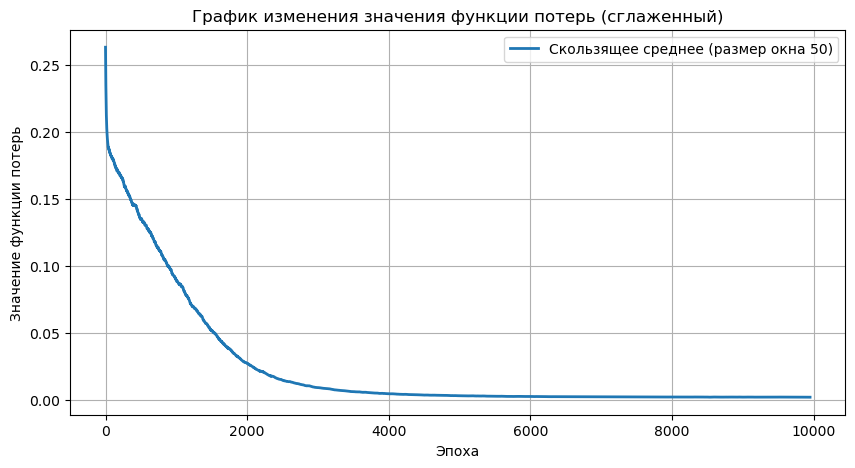

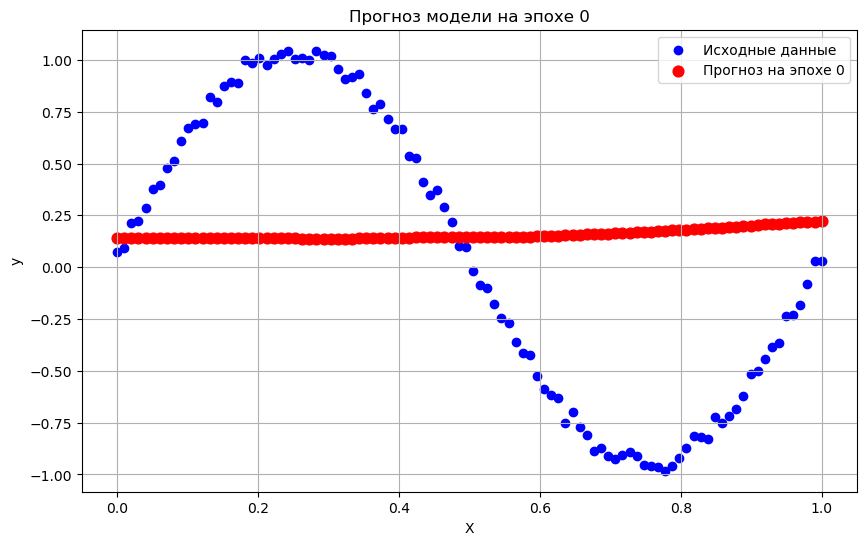

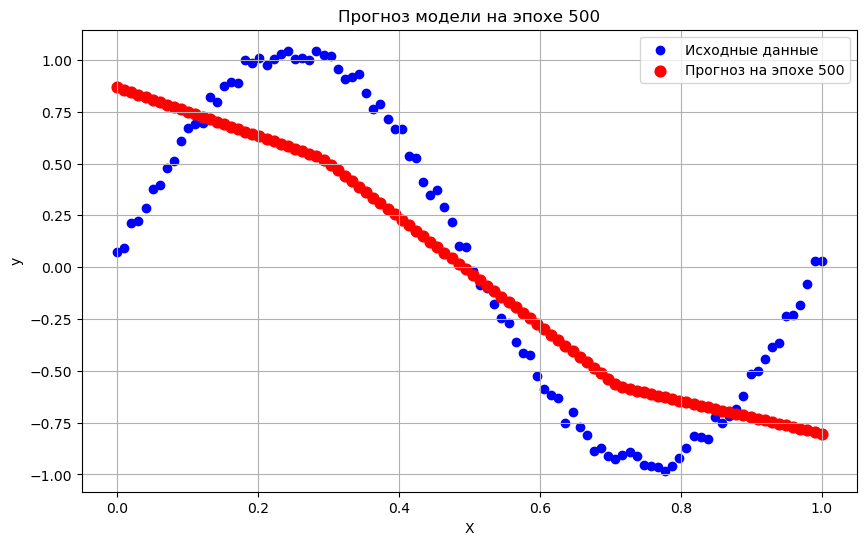

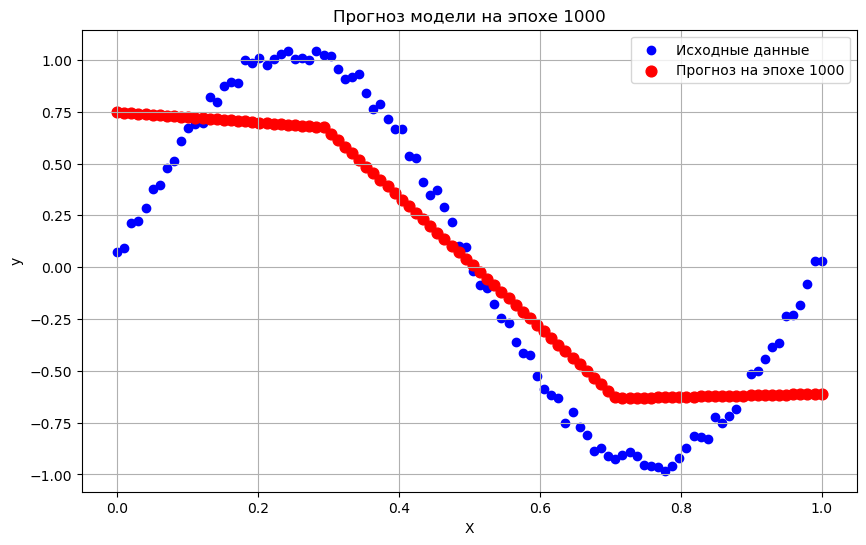

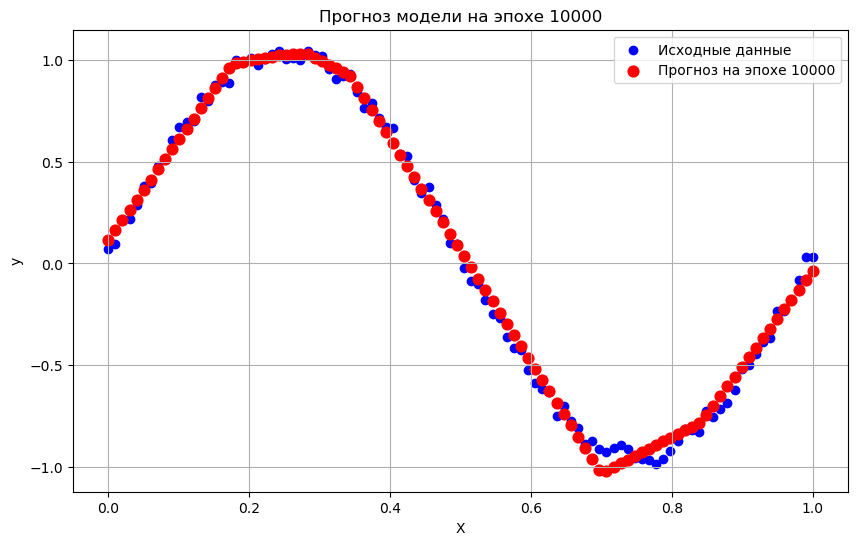

In [33]:
epoch_losses, predictions_at_epochs = train_model(model, criterion, optimizer, loader, X)
plot_loss_curve(epoch_losses, window_size=50)
plot_predictions(X, y, predictions_at_epochs)

<p class='task' id='2'></p>

2\. Повторите решение задачи 1, изменив модель. Для создания модели создайте объект класса `nn.Sequential`.

Предлагаемая архитектура нейронной сети:
1. Полносвязный слой с 50 нейронами
2. Активация Tanh
3. Полносвязный слой с 1 нейроном

- [ ] Проверено на семинаре

In [34]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [35]:
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = nn.Sequential(
    nn.Linear(in_features=1, out_features=50),
    nn.Tanh(),
    nn.Linear(in_features=50, out_features=1),
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

Epoch [0/10000], Loss: 0.6133
Epoch [1000/10000], Loss: 0.1955
Epoch [2000/10000], Loss: 0.1944
Epoch [3000/10000], Loss: 0.1821
Epoch [4000/10000], Loss: 0.1599
Epoch [5000/10000], Loss: 0.0917
Epoch [6000/10000], Loss: 0.0186
Epoch [7000/10000], Loss: 0.0023
Epoch [8000/10000], Loss: 0.0015
Epoch [9000/10000], Loss: 0.0018
Epoch [10000/10000], Loss: 0.0014


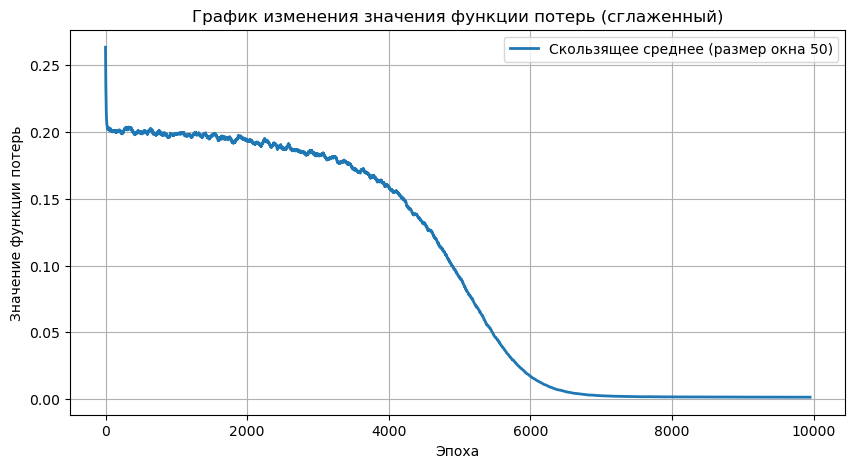

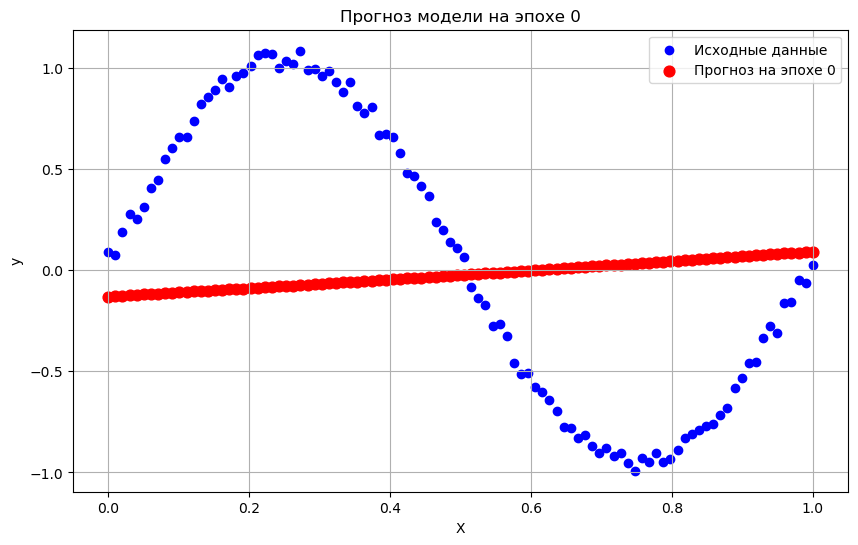

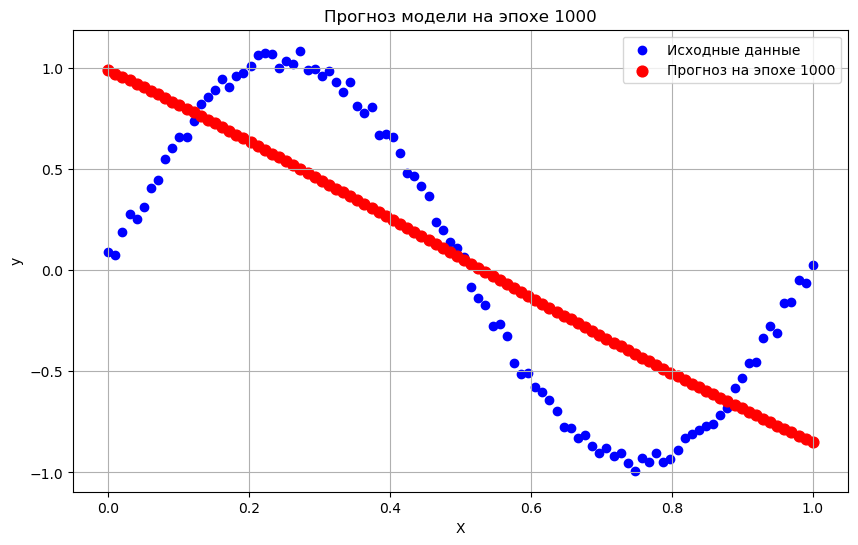

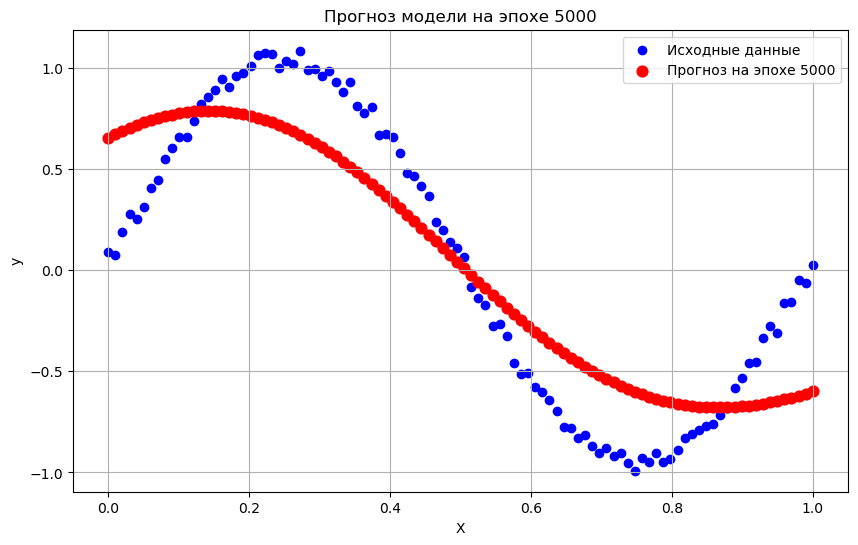

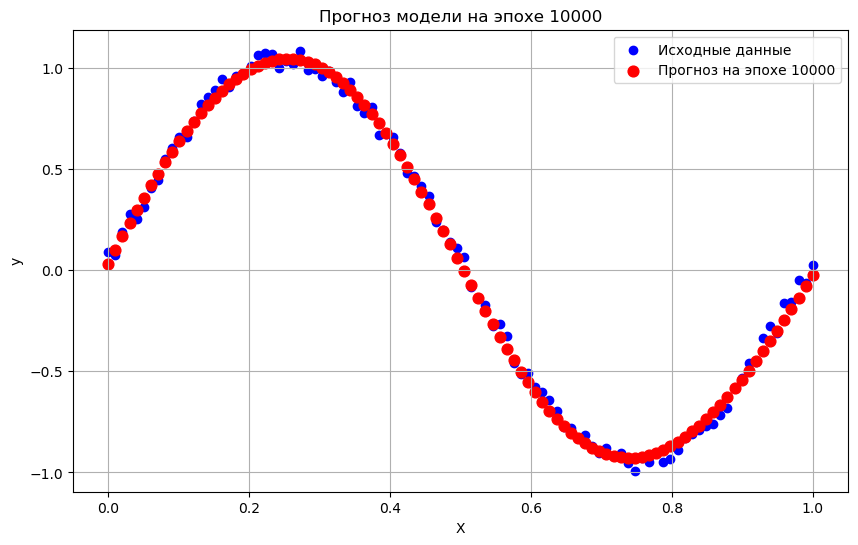

In [36]:
epoch_losses, predictions_at_epochs = train_model(model, criterion, optimizer, loader, X, log_epochs=(0, 1000, 5000, 10000))
plot_loss_curve(epoch_losses, window_size=50)
plot_predictions(X, y, predictions_at_epochs)

<p class='task' id='3'></p>

3\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Перенесите вычисления на GPU и сравните время обучения с и без использования GPU. Решение должно корректно работать в случае отсутствия GPU без дополнительных изменений в коде.

- [ ] Проверено на семинаре

In [37]:
from sklearn.datasets import make_regression
import torch as th
import time
import numpy as np

X, y, coef = make_regression(
    n_samples=10000,
    n_features=10,
    n_informative=6,
    coef=True,
    bias=0.5,
    random_state=42
)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [38]:
device = th.device('cpu')
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

model = nn.Sequential(
    nn.Linear(in_features=10, out_features=50),
    nn.Tanh(),
    nn.Linear(in_features=50, out_features=1),
).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [39]:
start_time = time.time()
epoch_losses, predictions_at_epochs = train_model(model, criterion, optimizer, loader, X, n_epochs=500, print_every=50)
end_time = time.time()
print(f'Время обучения на CPU: {end_time - start_time:.2f} секунд')

Epoch [0/500], Loss: 2292.3088
Epoch [50/500], Loss: 1.6325
Epoch [100/500], Loss: 1.1042
Epoch [150/500], Loss: 0.2937
Epoch [200/500], Loss: 0.1789
Epoch [250/500], Loss: 0.1082
Epoch [300/500], Loss: 0.0864
Epoch [350/500], Loss: 0.2432
Epoch [400/500], Loss: 0.0903
Epoch [450/500], Loss: 0.0984
Epoch [500/500], Loss: 0.0453
Время обучения на CPU: 73.77 секунд


In [40]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Используемое устройство: {device}')

Используемое устройство: cuda


In [41]:
X = X.to(device)
y = y.to(device)
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

model = nn.Sequential(
    nn.Linear(in_features=10, out_features=50),
    nn.Tanh(),
    nn.Linear(in_features=50, out_features=1),
).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [42]:
start_time = time.time()
epoch_losses, predictions_at_epochs = train_model(model, criterion, optimizer, loader, X, n_epochs=500, print_every=50)
end_time = time.time()
print(f'Время обучения на GPU: {end_time - start_time:.2f} секунд')

Epoch [0/500], Loss: 2212.9237
Epoch [50/500], Loss: 1.7715
Epoch [100/500], Loss: 1.8542
Epoch [150/500], Loss: 0.2632
Epoch [200/500], Loss: 0.2703
Epoch [250/500], Loss: 0.1283
Epoch [300/500], Loss: 0.0894
Epoch [350/500], Loss: 0.0642
Epoch [400/500], Loss: 0.0542
Epoch [450/500], Loss: 0.0442
Epoch [500/500], Loss: 0.0466
Время обучения на GPU: 77.32 секунд


<p class='task' id='4'></p>

4\. Повторите решение задач 1-2, используя для расчета значения функции потерь за эпоху метрику `MeanMetric` из пакета `torchmetrics`. Добавьте в цикл обучения расчет метрики $R^2$ (воспользуйтесь реализацией из `torchmetrics`). Выведите на экран график изменения значения функции потерь и метрики $R^2$ по эпохам в процессе обучения.

In [43]:
device = th.device('cpu')

In [44]:
import numpy as np
import torchmetrics as M

X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int, n_out: int) -> None:
        super(SineModel, self).__init__()
        self.fc1 = nn.Linear(in_features=n_features, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_out)
        self.relu = nn.ReLU()

    def forward(self, X: TensorType['batch', 'n_features']) -> TensorType['batch', 1]:
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = SineModel(n_features=1, n_hidden=100, n_out=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [45]:
def train_model_with_metrics(model, criterion, optimizer, loader, X_full, y_full, n_epochs=10000, print_every=1000):
    epoch_losses = []
    r2_scores = []

    loss_metric = M.MeanMetric()
    r2_metric = M.R2Score()
    for epoch in range(n_epochs+1):
        loss_metric.reset()  
        r2_metric.reset()
        
        for X_batch, y_batch in loader:
            model.train()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss_metric.update(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_metric.compute().item()
        epoch_losses.append(epoch_loss)

        model.eval()
        with th.no_grad():
            y_pred_full = model(X_full)
            r2_metric.update(y_pred_full, y_full)
            r2_score = r2_metric.compute().item()
            r2_scores.append(r2_score)

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {epoch_loss:.4f}, R²: {r2_score:.4f}')

    return epoch_losses, r2_scores

In [46]:
def plot_r2_scores(r2_scores):
    smoothed_r2_scores = moving_average(r2_scores, window_size=50)
    epochs = range(len(smoothed_r2_scores))
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, smoothed_r2_scores, label='Скользящее среднее (размер окна 50)', color='g', linewidth=2)
    plt.title('График изменения метрики R² по эпохам (сглаженный)')
    plt.xlabel('Эпоха')
    plt.ylabel('R²')
    plt.grid(True)
    plt.legend()
    plt.show()

Epoch [0/10000], Loss: 0.5332, R²: 0.1105
Epoch [1000/10000], Loss: 0.0762, R²: 0.8525
Epoch [2000/10000], Loss: 0.0177, R²: 0.9621
Epoch [3000/10000], Loss: 0.0067, R²: 0.9851
Epoch [4000/10000], Loss: 0.0050, R²: 0.9919
Epoch [5000/10000], Loss: 0.0026, R²: 0.9946
Epoch [6000/10000], Loss: 0.0019, R²: 0.9960
Epoch [7000/10000], Loss: 0.0018, R²: 0.9964
Epoch [8000/10000], Loss: 0.0015, R²: 0.9968
Epoch [9000/10000], Loss: 0.0017, R²: 0.9970
Epoch [10000/10000], Loss: 0.0014, R²: 0.9971


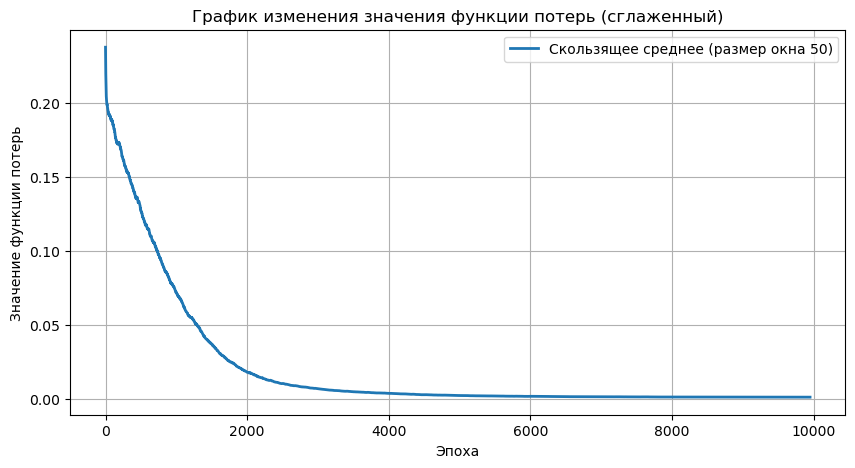

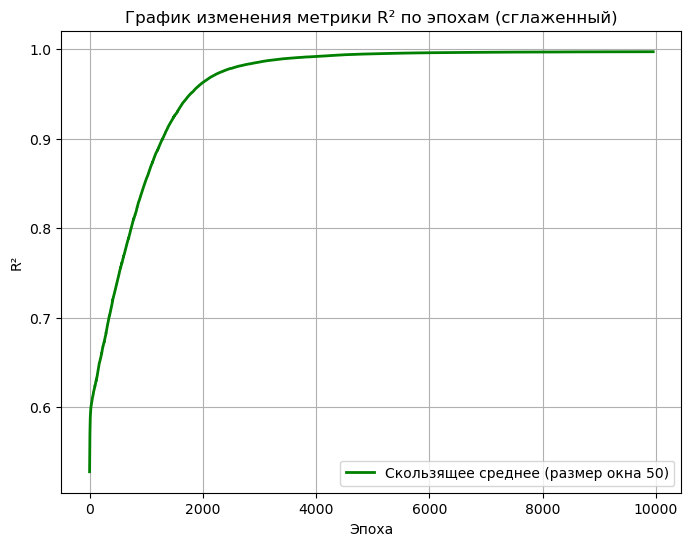

In [47]:
epoch_losses, r2_scores = train_model_with_metrics(model, criterion, optimizer, loader, X, y)
plot_loss_curve(epoch_losses, window_size=50)
plot_r2_scores(r2_scores)

<p class='task' id='5'></p>

5\. Повторите решение задач 1-2, изменив функцию потерь. Обучите модель, используя три функции потерь: `MSELoss`, `L1Loss` и `HuberLoss` - и выведите на одном графике динамику изменения метрики $R^2$ по эпохам для каждой модели в процессе обучения. Добавьте подписи полученных кривых.

- [ ] Проверено на семинаре

In [48]:
def plot_r2_comparison(r2_mse, r2_l1, r2_huber, window_size=50):
    r2_mse_smooth = moving_average(r2_mse, window_size)
    r2_l1_smooth = moving_average(r2_l1, window_size)
    r2_huber_smooth = moving_average(r2_huber, window_size)
    smooth_epochs = range(len(r2_mse_smooth))

    plt.figure(figsize=(10, 6))

    plt.plot(smooth_epochs, r2_mse_smooth, label='MSE Loss (сглаженный)', color='b', linewidth=2)
    plt.plot(smooth_epochs, r2_l1_smooth, label='L1 Loss (сглаженный)', color='g', linewidth=2)
    plt.plot(smooth_epochs, r2_huber_smooth, label='Huber Loss (сглаженный)', color='r', linewidth=2)

    plt.title('Динамика изменения метрики R² для разных функций потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('R²')
    plt.grid(True)
    plt.legend()
    plt.show()


In [49]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int, n_out: int) -> None:
        super(SineModel, self).__init__()
        self.fc1 = nn.Linear(in_features=n_features, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_out)
        self.relu = nn.ReLU()

    def forward(self, X: TensorType['batch', 'n_features']) -> TensorType['batch', 1]:
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = SineModel(n_features=1, n_hidden=100, n_out=1)
optimizer = optim.SGD(model.parameters(), lr=0.005)



criterion_mse = nn.MSELoss()
_, r2_mse = train_model_with_metrics(model, criterion_mse, optimizer, loader, X, y)

Epoch [0/10000], Loss: 0.5918, R²: 0.0381
Epoch [1000/10000], Loss: 0.1033, R²: 0.8021
Epoch [2000/10000], Loss: 0.0349, R²: 0.9255
Epoch [3000/10000], Loss: 0.0129, R²: 0.9738
Epoch [4000/10000], Loss: 0.0062, R²: 0.9875
Epoch [5000/10000], Loss: 0.0037, R²: 0.9929
Epoch [6000/10000], Loss: 0.0023, R²: 0.9953
Epoch [7000/10000], Loss: 0.0018, R²: 0.9965
Epoch [8000/10000], Loss: 0.0014, R²: 0.9972
Epoch [9000/10000], Loss: 0.0013, R²: 0.9975
Epoch [10000/10000], Loss: 0.0011, R²: 0.9979


In [50]:
criterion_l1 = nn.L1Loss()
model = SineModel(n_features=1, n_hidden=100, n_out=1)
optimizer = optim.SGD(model.parameters(), lr=0.005)

_, r2_l1 = train_model_with_metrics(model, criterion_l1, optimizer, loader, X, y)

Epoch [0/10000], Loss: 0.6342, R²: 0.0803
Epoch [1000/10000], Loss: 0.2225, R²: 0.8235
Epoch [2000/10000], Loss: 0.0620, R²: 0.9891
Epoch [3000/10000], Loss: 0.0631, R²: 0.9791
Epoch [4000/10000], Loss: 0.0544, R²: 0.9982
Epoch [5000/10000], Loss: 0.0456, R²: 0.9984
Epoch [6000/10000], Loss: 0.0238, R²: 0.9784
Epoch [7000/10000], Loss: 0.0416, R²: 0.9980
Epoch [8000/10000], Loss: 0.0393, R²: 0.9942
Epoch [9000/10000], Loss: 0.0302, R²: 0.9940
Epoch [10000/10000], Loss: 0.0319, R²: 0.9968


In [51]:
criterion_huber = nn.HuberLoss()
model = SineModel(n_features=1, n_hidden=100, n_out=1)
optimizer = optim.SGD(model.parameters(), lr=0.005)

_, r2_huber = train_model_with_metrics(model, criterion_huber, optimizer, loader, X, y)

Epoch [0/10000], Loss: 0.2684, R²: -0.0269
Epoch [1000/10000], Loss: 0.0639, R²: 0.7401
Epoch [2000/10000], Loss: 0.0375, R²: 0.8569
Epoch [3000/10000], Loss: 0.0175, R²: 0.9262
Epoch [4000/10000], Loss: 0.0101, R²: 0.9620
Epoch [5000/10000], Loss: 0.0054, R²: 0.9778
Epoch [6000/10000], Loss: 0.0039, R²: 0.9851
Epoch [7000/10000], Loss: 0.0025, R²: 0.9898
Epoch [8000/10000], Loss: 0.0019, R²: 0.9923
Epoch [9000/10000], Loss: 0.0015, R²: 0.9939
Epoch [10000/10000], Loss: 0.0013, R²: 0.9949


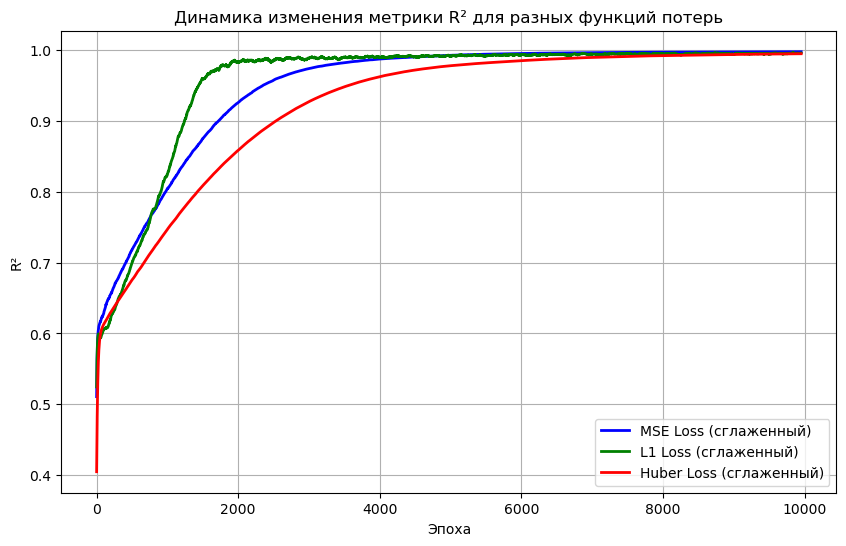

In [52]:
plot_r2_comparison(r2_mse, r2_l1, r2_huber)

<p class='task' id='6'></p>

6\. Повторите решение задач 1-2, разделив датасет на обучающую и тестовую выборку в соотношении 80% на 20%. Обучите модель. Для тестовой выборки посчитайте и выведите на экран значения метрик:

- MAE;
- MAPE;
- MSE;
- MSLE (MeanSquaredLogError).


- [ ] Проверено на семинаре

In [53]:
from torch.utils.data import random_split

In [54]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

In [55]:
class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int, n_out: int) -> None:
        super(SineModel, self).__init__()
        self.fc1 = nn.Linear(in_features=n_features, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_out)
        self.relu = nn.ReLU()

    def forward(self, X: TensorType['batch', 'n_features']) -> TensorType['batch', 1]:
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [56]:
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = SineModel(n_features=1, n_hidden=100, n_out=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [57]:
X = th.linspace(0, 1, 100).view(-1, 1)
y = th.sin(2 * th.pi * X) + 0.1 * th.rand(X.size())

class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int, n_out: int) -> None:
        super(SineModel, self).__init__()
        self.fc1 = nn.Linear(in_features=n_features, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_out)
        self.relu = nn.ReLU()

    def forward(self, X: TensorType['batch', 'n_features']) -> TensorType['batch', 1]:
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = SineModel(n_features=1, n_hidden=100, n_out=1)
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [58]:
def train_model_with_metrics_new(model, criterion, optimizer, loader, n_epochs=10000, print_every=1000):
    for epoch in range(n_epochs + 1):
        model.train()
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.4f}')

In [59]:
train_model_with_metrics_new(model, criterion, optimizer, train_loader)

Epoch [0/10000], Loss: 0.5952
Epoch [1000/10000], Loss: 0.1204
Epoch [2000/10000], Loss: 0.0755
Epoch [3000/10000], Loss: 0.0414
Epoch [4000/10000], Loss: 0.0059
Epoch [5000/10000], Loss: 0.0075
Epoch [6000/10000], Loss: 0.0048
Epoch [7000/10000], Loss: 0.0035
Epoch [8000/10000], Loss: 0.0022
Epoch [9000/10000], Loss: 0.0023
Epoch [10000/10000], Loss: 0.0008


In [60]:
model.eval()
y_pred_list, y_test_list = [], []
with th.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred_list.append(y_pred)
        y_test_list.append(y_batch)

y_pred_test = th.cat(y_pred_list)
y_test = th.cat(y_test_list)

mae = M.MeanAbsoluteError()(y_pred_test, y_test).item()
mape = M.MeanAbsolutePercentageError()(y_pred_test, y_test).item()
mse = M.MeanSquaredError()(y_pred_test, y_test).item()
msle = M.MeanSquaredLogError()(y_pred_test, y_test).item()

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MSLE: {msle:.4f}')

MAE: 0.0463
MAPE: 0.1576
MSE: 0.0034
MSLE: 0.0229
